# _Music genre classification_

Natalia Pludra, Jakub Cieśluk, Patryk Kapłan

We decided to use structured data with around 30,000 songs from the Spotify API. Each row of our table contains title, genre and some features of the song. Our goal is to create classification models which predict the genre based on song features.

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from scipy.stats import randint, uniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
from tqdm.auto import tqdm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss
from sklearn.preprocessing import label_binarize

# Data

First, we want to take a closer look at our data and prepare it for building models.

In [10]:
# load data & take necessary columns
df = pd.read_csv('input/spotify_songs.csv', sep=',')

songs = df[['playlist_genre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
print(songs.info())

all_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32833 entries, 0 to 32832
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   playlist_genre    32833 non-null  object 
 1   danceability      32833 non-null  float64
 2   energy            32833 non-null  float64
 3   key               32833 non-null  int64  
 4   loudness          32833 non-null  float64
 5   mode              32833 non-null  int64  
 6   speechiness       32833 non-null  float64
 7   acousticness      32833 non-null  float64
 8   instrumentalness  32833 non-null  float64
 9   liveness          32833 non-null  float64
 10  valence           32833 non-null  float64
 11  tempo             32833 non-null  float64
 12  duration_ms       32833 non-null  int64  
dtypes: float64(9), int64(3), object(1)
memory usage: 3.3+ MB
None


In [3]:
songs.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000,32833.000000
mean,0.654850,0.698619,5.374471,-6.719499,0.565711,0.107068,0.175334,0.084747,0.190176,0.510561,120.881132,225799.811622
std,0.145085,0.180910,3.611657,2.988436,0.495671,0.101314,0.219633,0.224230,0.154317,0.233146,26.903624,59834.006182
min,0.000000,0.000175,0.000000,-46.448000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4000.000000
25%,0.563000,0.581000,2.000000,-8.171000,0.000000,0.041000,0.015100,0.000000,0.092700,0.331000,99.960000,187819.000000
50%,0.672000,0.721000,6.000000,-6.166000,1.000000,0.062500,0.080400,0.000016,0.127000,0.512000,121.984000,216000.000000
75%,0.761000,0.840000,9.000000,-4.645000,1.000000,0.132000,0.255000,0.004830,0.248000,0.693000,133.918000,253585.000000
max,0.983000,1.000000,11.000000,1.275000,1.000000,0.918000,0.994000,0.994000,0.996000,0.991000,239.440000,517810.000000


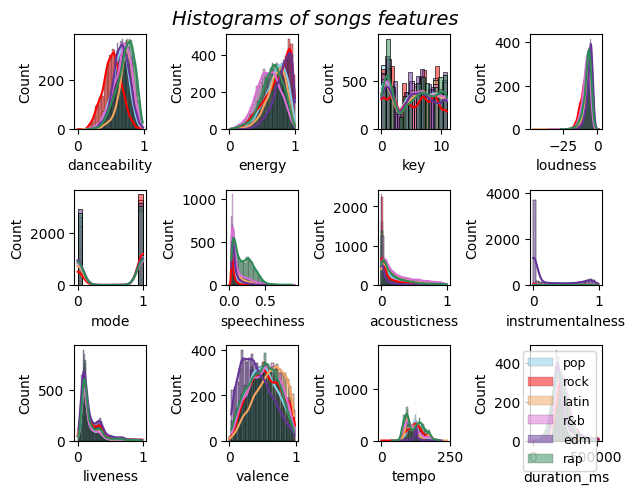

In [11]:
pop_df = songs[songs['playlist_genre']=='pop']
rock_df = songs[songs['playlist_genre']=='rock']
latin_df = songs[songs['playlist_genre']=='latin']
r_and_b_df = songs[songs['playlist_genre']=='r&b']
edm_df = songs[songs['playlist_genre']=='edm']
rap_df = songs[songs['playlist_genre']=='rap']

num=0
for col in all_features:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

plt.tight_layout()
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9')
plt.show()

As we can see, ranges for the fetures differ a lot, which can significantly bias our results. Because of that, we will work on normalized data. What is more, some histograms are skewed. We will try to use logarithm transformation to reduce skewness of variables (to make data more symmetric) and reduce the impact of outliers. We will do these transformations a little bit later.

Below, we present all genres which are in the data.

In [12]:
print("Total number of songs: ", len(songs))
print(songs['playlist_genre'].value_counts())

Total number of songs:  32833
playlist_genre
edm      6043
rap      5746
pop      5507
r&b      5431
latin    5155
rock     4951
Name: count, dtype: int64


The number of rows for each genre is different so we will remove some rows to equal them.

In [13]:
min = songs['playlist_genre'].value_counts().min()
# Take only min songs from each genre
songs_grouped = songs.groupby('playlist_genre').head(min)

In [14]:
map_genres = {genre: i for i, genre in enumerate(songs_grouped['playlist_genre'].unique())}
map_genres 

{'pop': 0, 'rap': 1, 'rock': 2, 'latin': 3, 'r&b': 4, 'edm': 5}

In [15]:
songs_mapped = songs_grouped.copy()
songs_mapped['playlist_genre'] = songs_mapped['playlist_genre'].map(map_genres)

In [16]:
songs_data_non_normalized = songs_grouped.drop('playlist_genre', axis=1)
songs_target = songs_grouped['playlist_genre']
songs_target = songs_target.map(map_genres)

# Normalize data to 0-1 range
songs_data = (songs_data_non_normalized - songs_data_non_normalized.min()) / (songs_data_non_normalized.max() - songs_data_non_normalized.min())

c:\Users\MachB\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


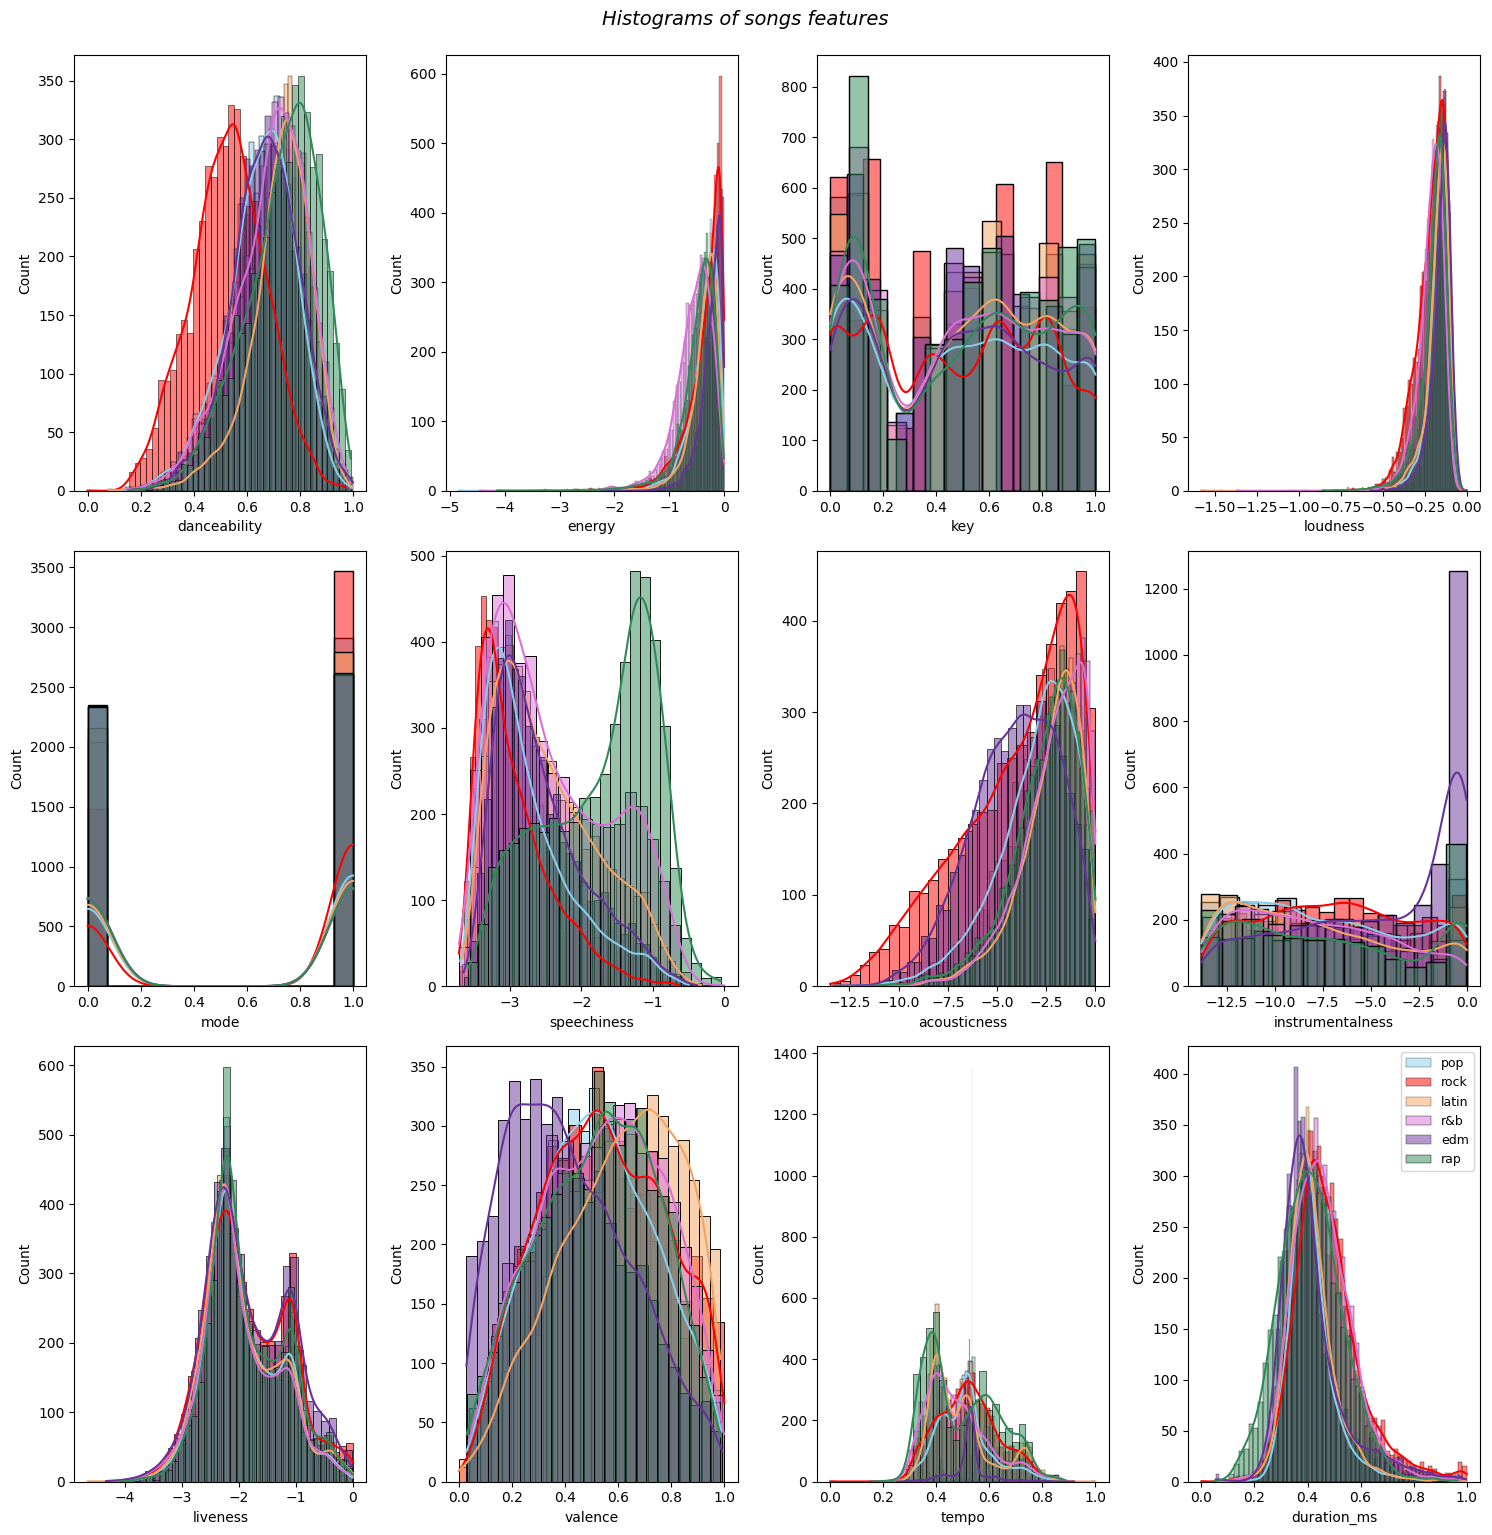

In [18]:
# normalized data + log transformation
songs_log = songs_data.copy()
songs_log['playlist_genre'] = songs_grouped['playlist_genre']

songs_log['energy'] = np.log(songs_log['energy'])
songs_log['loudness'] = np.log(songs_log['loudness'])
songs_log['speechiness'] = np.log(songs_log['speechiness'])
songs_log['acousticness'] = np.log(songs_log['acousticness'])
songs_log['instrumentalness'] = np.log(songs_log['instrumentalness'])
songs_log['liveness'] = np.log(songs_log['liveness'])

pop_df = songs_log[songs_log['playlist_genre']=='pop']
rock_df = songs_log[songs_log['playlist_genre']=='rock']
latin_df = songs_log[songs_log['playlist_genre']=='latin']
r_and_b_df = songs_log[songs_log['playlist_genre']=='r&b']
edm_df = songs_log[songs_log['playlist_genre']=='edm']
rap_df = songs_log[songs_log['playlist_genre']=='rap']

num=0
for col in all_features:
    num+=1
    plt.subplot(3,4, num)
    plt.rcParams['figure.figsize'] = [15, 15]

    sns.histplot(data=pop_df,x=col, color="skyblue", label="pop", kde=True)
    sns.histplot(data=rock_df,x=col, color="red", label="rock", kde=True)
    sns.histplot(data=latin_df,x=col, color="sandybrown", label="latin", kde=True)
    sns.histplot(data=r_and_b_df,x=col, color="orchid", label="r&b", kde=True)
    sns.histplot(data=edm_df,x=col, color="rebeccapurple", label="edm", kde=True)
    sns.histplot(data=rap_df,x=col, color="seagreen", label="rap", kde=True)

plt.tight_layout()
plt.suptitle("Histograms of songs features", fontsize=14, fontweight=0, color='black', style='italic', y=1.02)
plt.legend(loc="upper right",fontsize='9')
plt.show()

Histograms of speechiness, acousticness, instrumentalness and liveness look better after logarithm transformation.

## Confusions caused by duplicates


In [19]:
# Remove duplicates
duplicates = songs.duplicated()
print("Number of duplicate rows: ", duplicates.sum())

# songs_no_duplicates = songs.drop_duplicates()


Number of duplicate rows:  3041


We have performed tests with and without removing duplicated rows. Turns out leaving duplicates yields much better result (almost 5% improvement for some models).

In [20]:
grouped_by_data = songs_mapped.groupby(all_features)
# result_list_of_lists = [group['playlist_genre'].values for _, group in grouped_by_data]
result_list_of_lists = [np.unique(group['playlist_genre'].values) for _, group in grouped_by_data]

In [21]:
# empty numpy array
real = []
predicted = []
for lst in result_list_of_lists:
    for i in range(len(lst)):
        for j in range(i+1, len(lst)):
            if lst[i] == lst[j]:
                continue
            real.append(lst[i])
            predicted.append(lst[j])
            real.append(lst[j])
            predicted.append(lst[i])

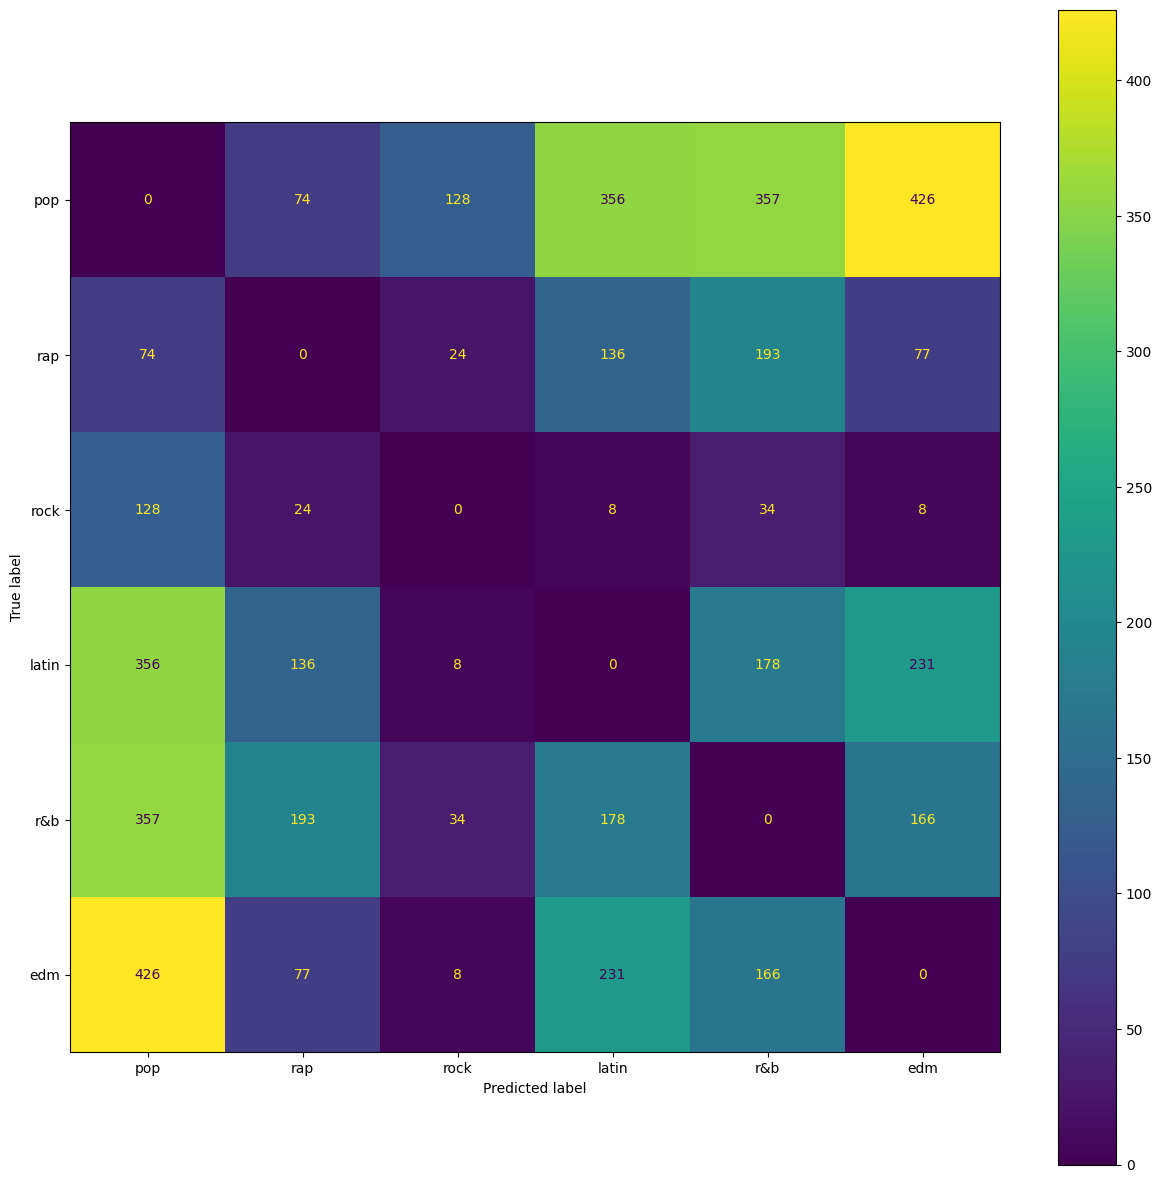

In [22]:
conf_matrix = confusion_matrix(real,predicted)

disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Data split

In [23]:
# train-test split
songs_data_train2, songs_data_test2, songs_target_train2, songs_target_test2 = train_test_split(songs_data, songs_target, test_size=0.15, random_state=0)

print("Training set size: ", len(songs_data_train2))
print("Test set size: ", len(songs_data_test2))

Training set size:  25250
Test set size:  4456


# Models

## Naive bayes classifier

In [45]:
naive_bayes_model = GaussianNB()

naive_bayes_model.fit(songs_data_train2, songs_target_train2)
y_pred = naive_bayes_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)

print("Accuracy: ", accuracy)

Accuracy:  0.44367145421903054


In [44]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

20.05211327460086


Each feature has the same influence on the decision.

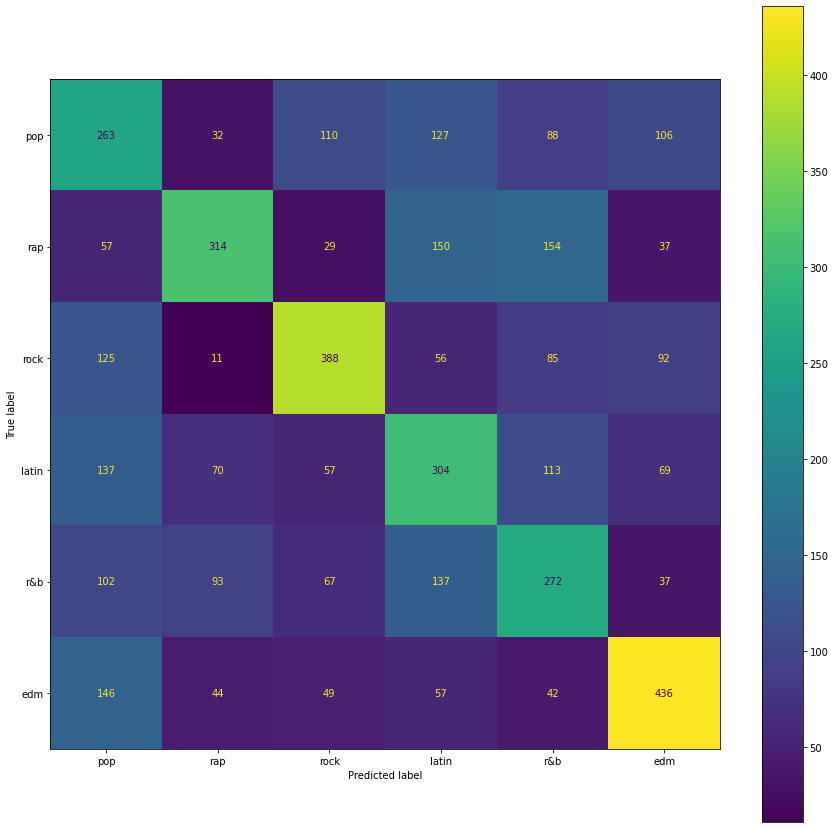

In [21]:
# confusion matrix (to evaluate the accuracy of a classification)
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Multiclass Logistic Regression

In [46]:
mlr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=1000)
mlr.fit(songs_data_train2, songs_target_train2)
y_pred = mlr.predict(songs_data_test2)

accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.47262118491921007


In [47]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

19.0086592155353


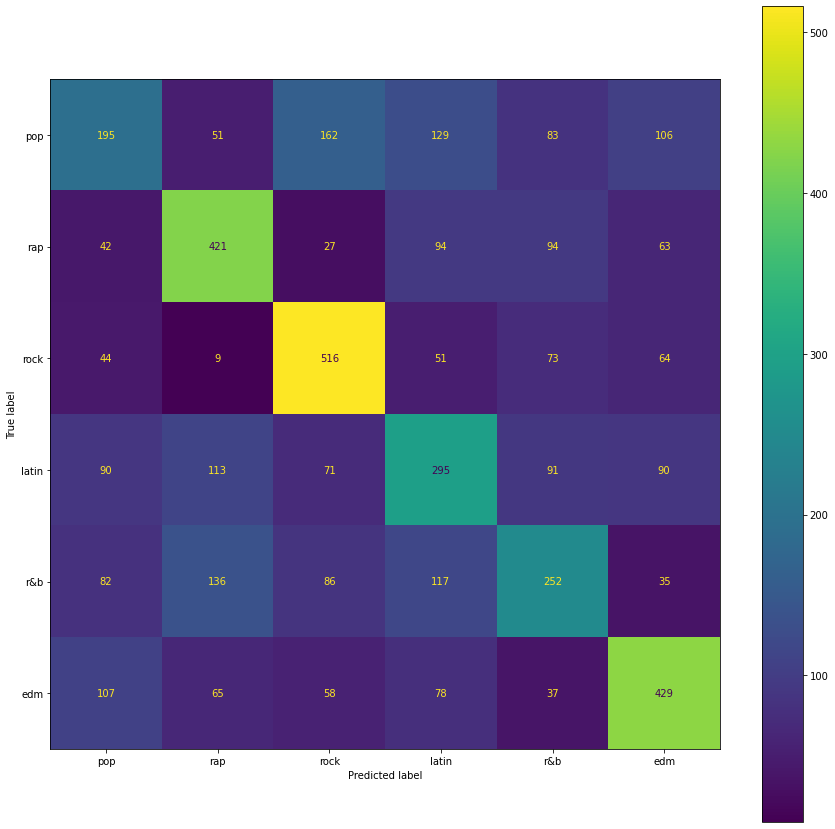

In [23]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Decision tree

In [24]:
# Decision tree, looking for the best parameters
decision_tree_model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [7,9,11],
    'min_samples_leaf': [3,4,5],
    'min_samples_split': [6,7,8]
}

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(songs_data_train2, songs_target_train2)
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best params:", best_params)

y_pred = best_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

Best params: {'max_depth': 11, 'min_samples_leaf': 5, 'min_samples_split': 7}
Accuracy:  0.47015260323159785


In [52]:
# Decision tree, creating new model using best params
decision_tree_model = DecisionTreeClassifier(max_depth=11, min_samples_leaf=5, min_samples_split=7)
decision_tree_model.fit(songs_data_train2, songs_target_train2)
y_pred = decision_tree_model.predict(songs_data_test2)

y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

19.12190229171296


In [69]:
# feature importances
feature_importances_dt = pd.Series(decision_tree_model.feature_importances_, index=songs_data_train2.columns)
feature_importances_dt

danceability        0.159616
energy              0.088359
key                 0.009230
loudness            0.070593
mode                0.004143
speechiness         0.168330
acousticness        0.058928
instrumentalness    0.093870
liveness            0.021553
valence             0.071100
tempo               0.171859
duration_ms         0.082418
dtype: float64

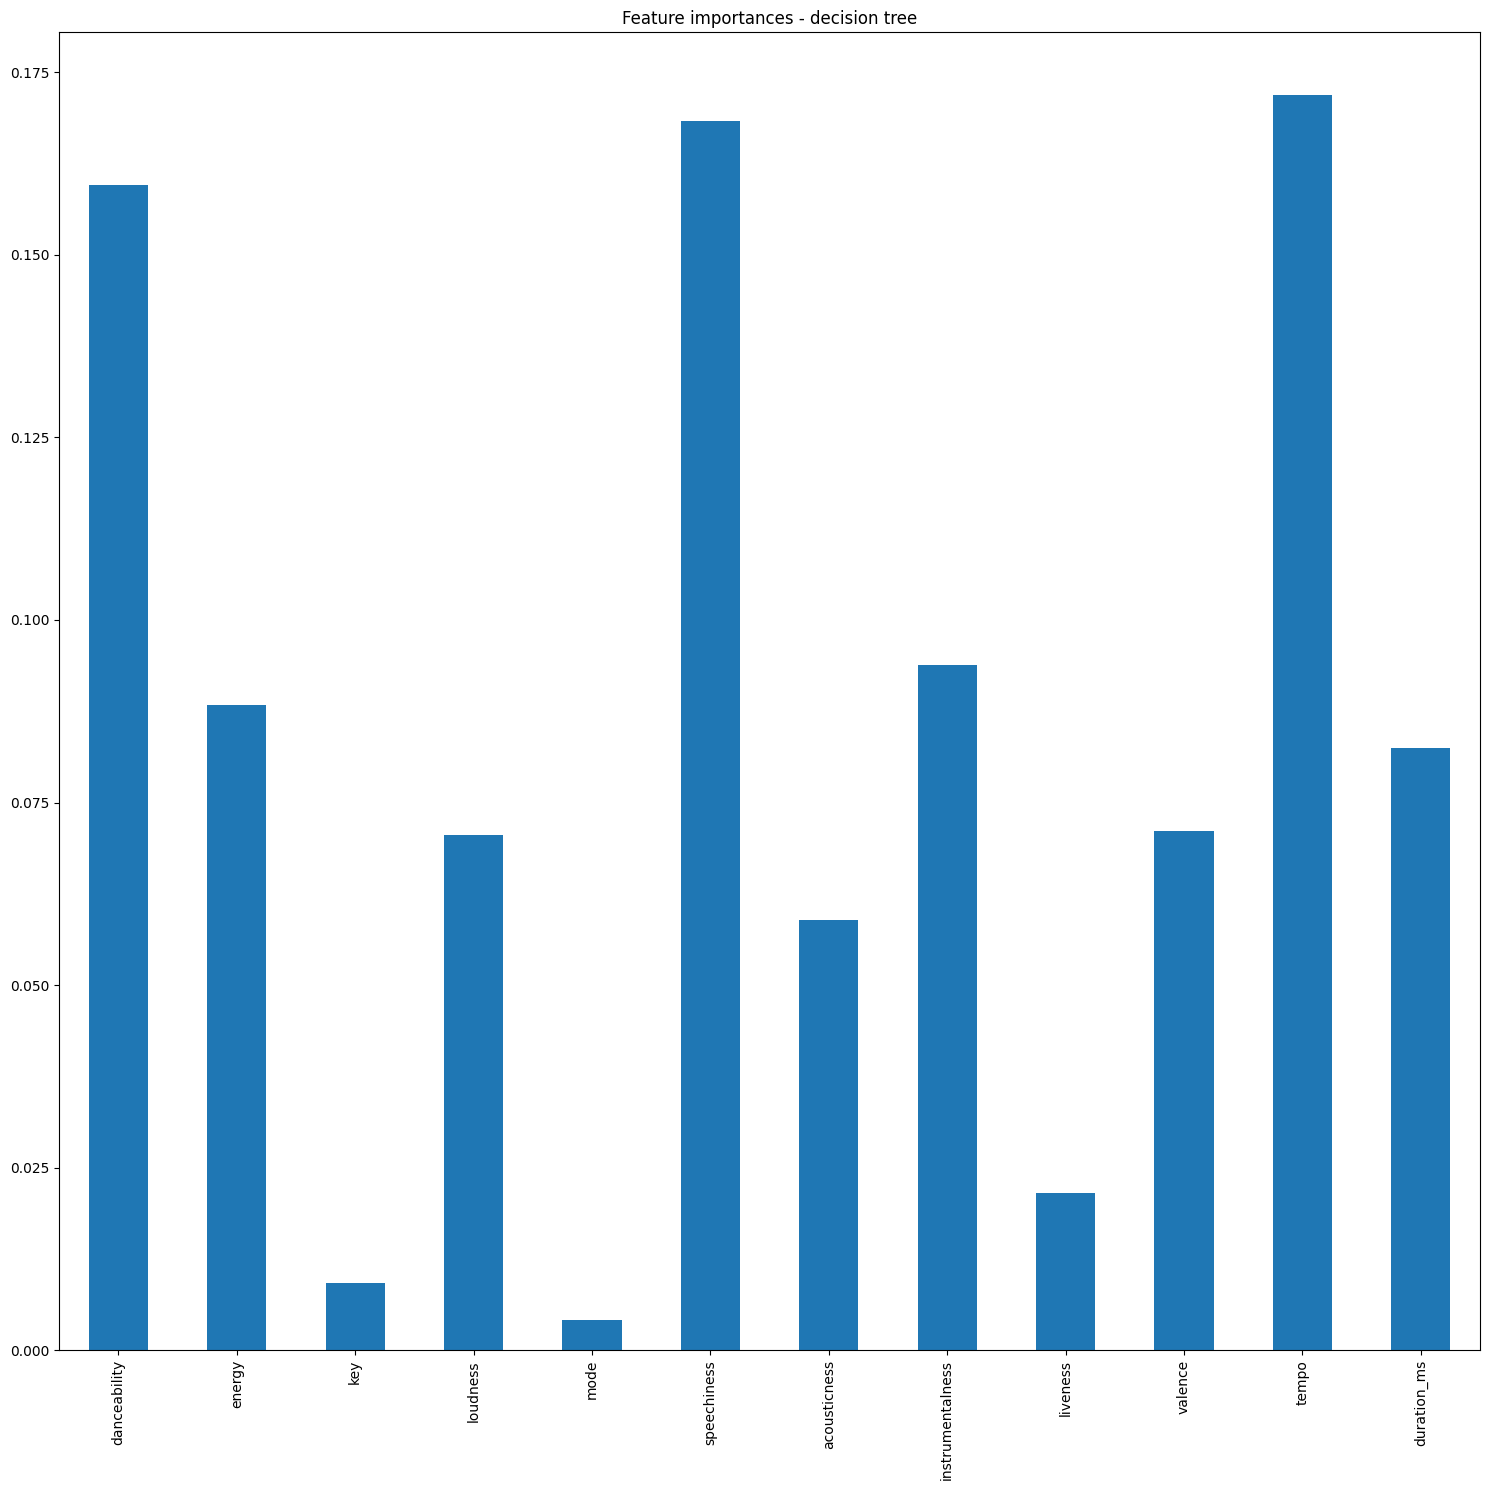

In [70]:
fig, ax = plt.subplots()
feature_importances_dt.plot.bar(ax=ax)
ax.set_title("Feature importances - decision tree")
fig.tight_layout()

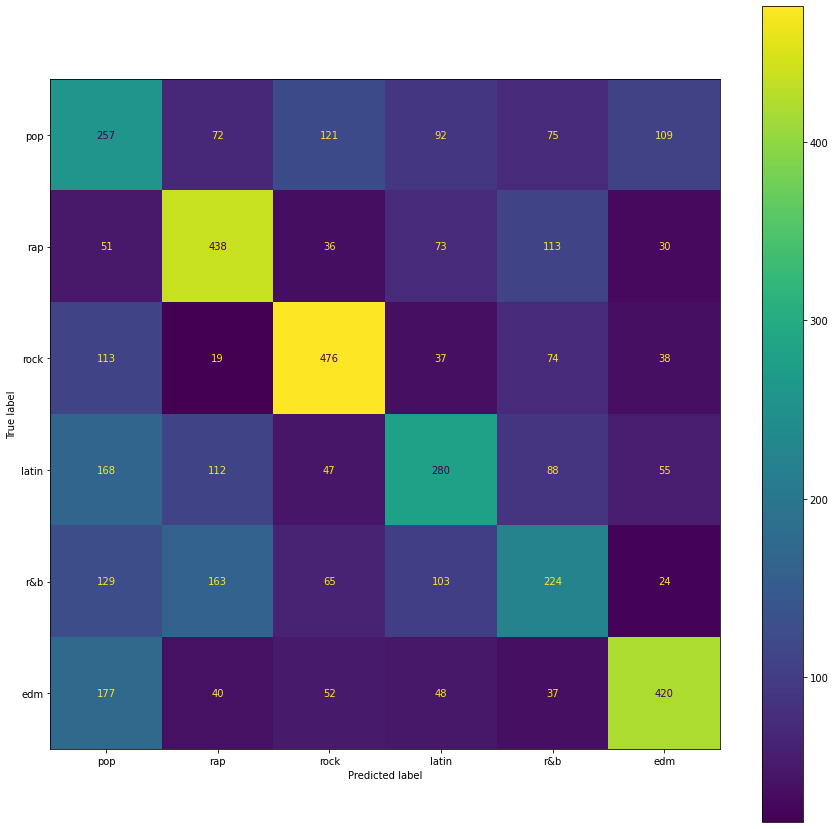

In [27]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Random forest

In [30]:
def make_random_search(model, param_distributions):
    return RandomizedSearchCV(
        model,
        param_distributions,
        n_iter=50,
        cv=3,
        scoring='accuracy',  # Use accuracy as the metric
        random_state=42
    )

In [31]:
# Random forest
random_forest_model = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample between 50 and 200
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = make_random_search(random_forest_model, param_dist)
random_search.fit(songs_data_train2, songs_target_train2)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best model from the search
best_random_forest_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred = best_random_forest_model.predict(songs_data_test2)

# Calculate accuracy
accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)


Best Hyperparameters: {'max_depth': 40, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 173}
Accuracy:  0.5623877917414721


In [54]:
# Random forest, creating model using best params

random_forest_model = RandomForestClassifier(random_state=42, max_depth=40, min_samples_leaf=2, min_samples_split=2, n_estimators=173)
random_forest_model.fit(songs_data_train2, songs_target_train2)
y_pred = random_forest_model.predict(songs_data_test2)

y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

15.773142753316531


In [71]:
# feature importances
feature_importances_rf = pd.Series(random_forest_model.feature_importances_, index=songs_data_train2.columns)
feature_importances_rf

danceability        0.122098
energy              0.093978
key                 0.039753
loudness            0.084990
mode                0.012256
speechiness         0.126335
acousticness        0.089671
instrumentalness    0.076167
liveness            0.060634
valence             0.088281
tempo               0.115448
duration_ms         0.090389
dtype: float64

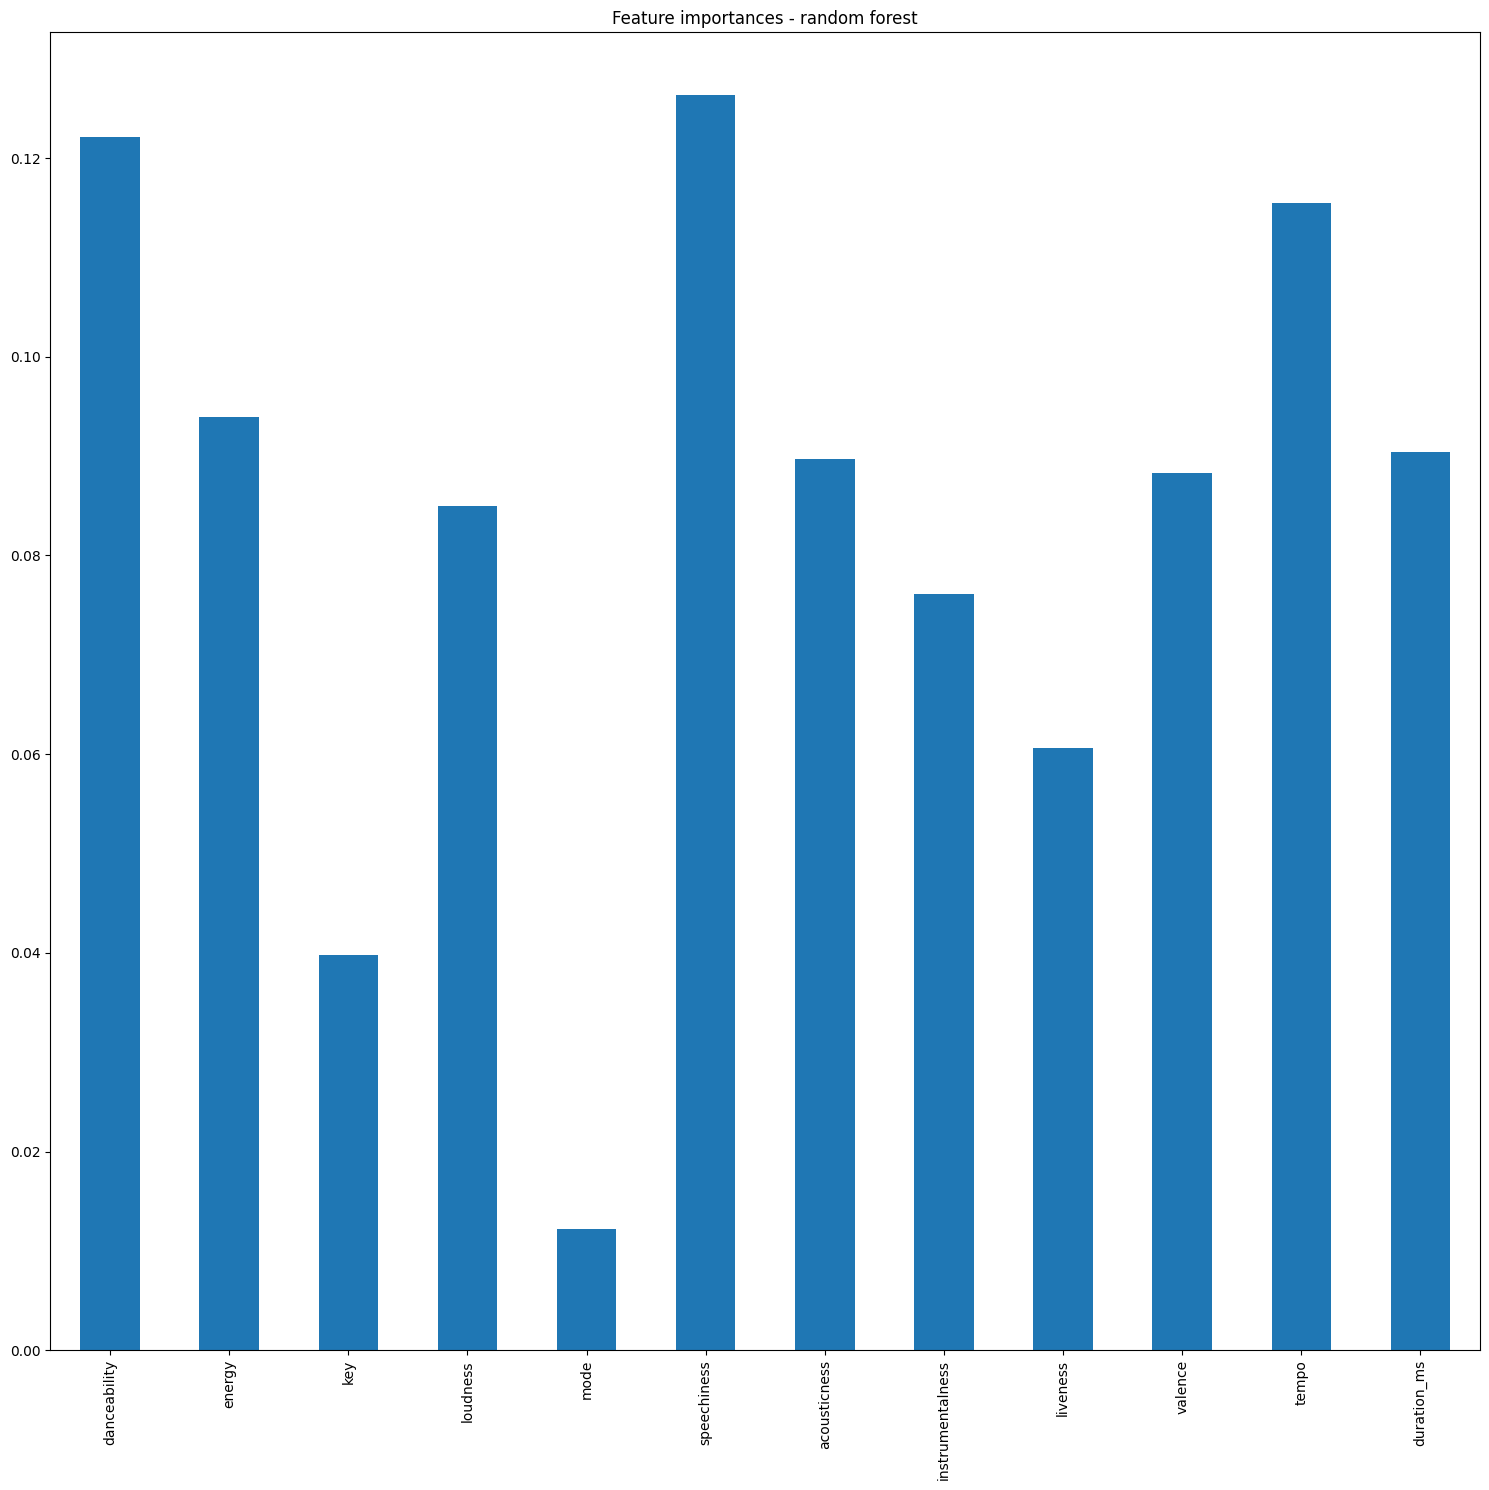

In [72]:
fig, ax = plt.subplots()
feature_importances_rf.plot.bar(ax=ax)
ax.set_title("Feature importances - random forest")
fig.tight_layout()

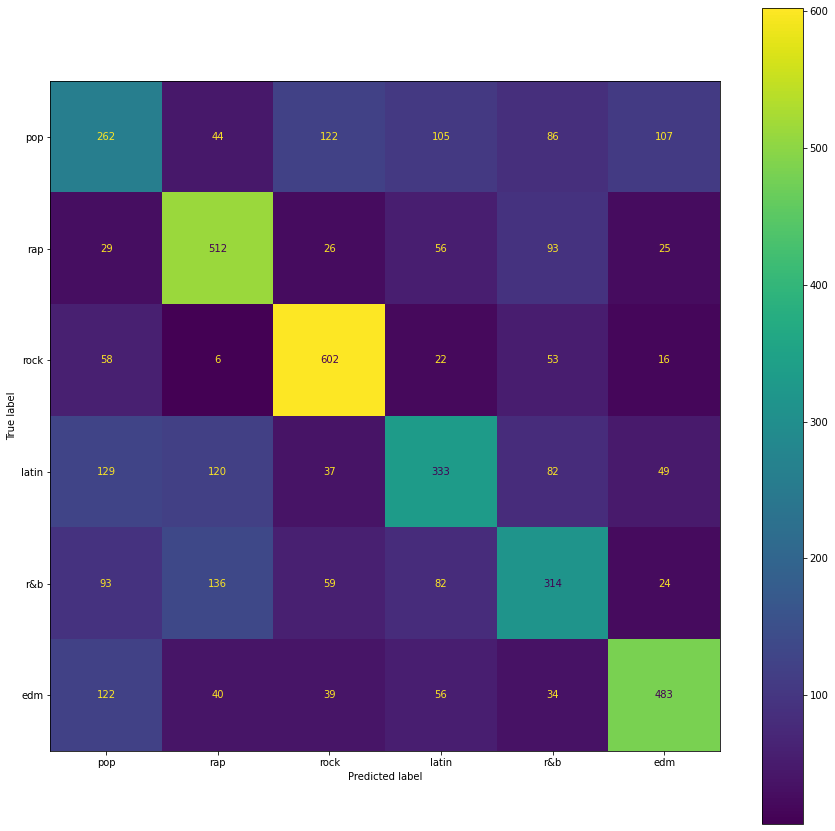

In [34]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## KNeighborsClassifier

### KNN on not normalized data

In [25]:
songs_data_train_nn, songs_data_test_nn, songs_target_train_nn, songs_target_test_nn = train_test_split(songs_data_non_normalized, songs_target, test_size=0.15, random_state=0)

In [52]:
results = []
for k in tqdm(np.arange(1,35)):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    # knn_model.fit(songs_data_train_nn, songs_target_train_nn)
    # y_pred = knn_model.predict(songs_data_test_nn)
    # accuracy = accuracy_score(songs_target_test_nn, y_pred)
    err = cross_val_score(knn_model,songs_data_train_nn,songs_target_train_nn,cv=5)
    results.append({'K':k, 'error_rate': err})
                   
# results_df = pd.DataFrame(results)
# results_df.loc[results_df['error_rate']==results_df['error_rate'].max()]
    
results_list = list(map(lambda x: (x['K'], x['error_rate'].mean()), results))
results_df = pd.DataFrame(results_list)
results_df.loc[results_df[1]==results_df[1].max()]

100%|██████████| 34/34 [01:38<00:00,  2.91s/it]


,0,1
0,1,0.291129


In [60]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=1)
knn_model.fit(songs_data_train_nn, songs_target_train_nn)
y_pred = knn_model.predict(songs_data_test_nn)
accuracy = accuracy_score(songs_target_test_nn, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.30587971274685816


In [61]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

25.018631044106677


As we see, results for not normalized data are much worse.

### KNN on normalized data

In [38]:
# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,songs_data_train2,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

In [39]:
results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
22,23,0.466614


In [62]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=23)
knn_model.fit(songs_data_train2, songs_target_train2)
y_pred = knn_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.46970377019748655


In [63]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

19.113813500557413


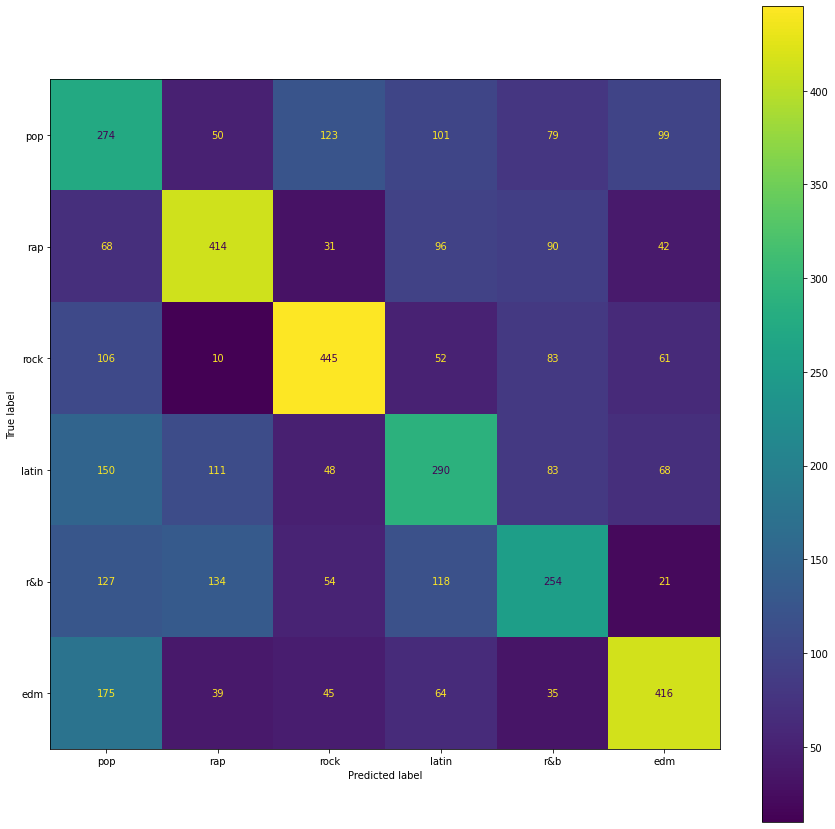

In [41]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

### KNN after log transformation

In [64]:
train_log = songs_data_train2.copy()
test_log = songs_data_test2.copy()

small_constant = 1e-10
train_log['speechiness'] = np.log(train_log['speechiness'] + small_constant)
train_log['acousticness'] = np.log(train_log['acousticness'] + small_constant)
train_log['liveness'] = np.log(train_log['liveness'] + small_constant)
train_log['instrumentalness'] = np.log(train_log['instrumentalness'] + small_constant)

test_log['speechiness'] = np.log(test_log['speechiness'] + small_constant)
test_log['acousticness'] = np.log(test_log['acousticness'] + small_constant)
test_log['liveness'] = np.log(test_log['liveness'] + small_constant)
test_log['instrumentalness'] = np.log(test_log['instrumentalness'] + small_constant)

In [43]:
# cross validation
res = []
for k in np.arange(1,30):
    knn_model = KNeighborsClassifier(n_neighbors=k)
    er = cross_val_score(knn_model,train_log,songs_target_train2,cv=5)
    res.append({'K':k, 'err_rate': er})

results = list(map(lambda x: (x['K'], x['err_rate'].mean()), res))
results_df = pd.DataFrame(results)
results_df.loc[results_df[1]==results_df[1].max()]

,0,1
26,27,0.392871


In [65]:
# accuracy on test set
knn_model = KNeighborsClassifier(n_neighbors=27)
knn_model.fit(train_log, songs_target_train2)
y_pred = knn_model.predict(test_log)
accuracy = accuracy_score(songs_target_test2,y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.4014811490125673


In [66]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

21.57280601184368


### KNN on important features

Let's try to consider only the features with high `feature importance` in both random forest and decision trees and use them for the KNN classifier

In [73]:
feature_importances = feature_importances_dt + feature_importances_rf
print(feature_importances.sort_values(ascending=False))

speechiness         0.294665
tempo               0.287307
danceability        0.281714
energy              0.182338
duration_ms         0.172807
instrumentalness    0.170037
valence             0.159381
loudness            0.155583
acousticness        0.148599
liveness            0.082187
key                 0.048983
mode                0.016399
dtype: float64


In [55]:
res = []
for n_features in tqdm(np.arange(1, len(feature_importances))):
    important_columns = feature_importances.sort_values(ascending=False).index[:n_features]
    important_data = songs_data[important_columns]
    important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target, test_size=0.15, random_state=0)
    # cross validation
    for k in np.arange(1,40):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        er = cross_val_score(knn_model,important_data_train,important_target_train,cv=5)
        res.append({'n_feat': n_features, 'K':k, 'err_rate': er.mean()})


  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [35:37<00:00, 194.33s/it]


In [56]:
# find best k for each number of features
results_df = pd.DataFrame(res)
results_df = results_df.sort_values('err_rate', ascending=False)
results_df = results_df.groupby('n_feat').head(1)
results_df = results_df.reset_index(drop=True)
results_df

,n_feat,K,err_rate
0,9,36,0.501069
1,8,38,0.499406
2,10,30,0.495248
3,7,39,0.488792
4,11,38,0.472356
5,6,33,0.472158
6,5,38,0.465188
7,4,33,0.447485
8,3,38,0.423129
9,2,31,0.381030


In [74]:
important_columns = feature_importances.sort_values(ascending=False).index[:9]
important_data = songs_data_train2[important_columns]
important_data_train, important_data_test, important_target_train, important_target_test = train_test_split(important_data, songs_target_train2, test_size=0.15, random_state=0)

knn_model = KNeighborsClassifier(n_neighbors=36)
knn_model.fit(important_data_train, important_target_train)
y_pred = knn_model.predict(important_data_test)
accuracy = accuracy_score(important_target_test, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.5089757127771911


In [76]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(important_target_test, classes=list(set(important_target_test)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

17.698309214297225


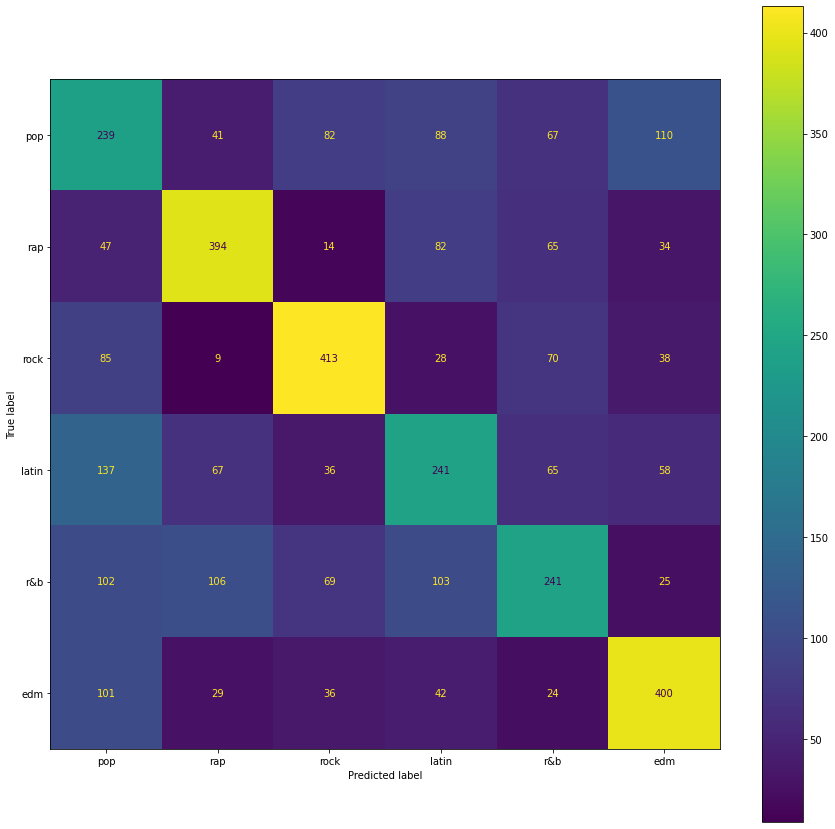

In [58]:
# confusion matrix
conf_matrix = confusion_matrix(important_target_test,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Support Vector Machine

In [77]:
# Support Vector Machine
clf = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)
clf.fit(songs_data_train2, songs_target_train2)
y_pred = clf.predict(songs_data_test2)

accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.5112208258527827


In [78]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

17.617387136781225


In [60]:
svm_model = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4)

# Define the hyperparameter grid
param_dist = {
    'C': uniform(0.1, 10),        # Randomly sample C from a uniform distribution between 0.1 and 10
    'gamma': ['scale', 'auto'],   # Choose between 'scale' and 'auto' for gamma
    'coef0': uniform(0, 1)         # Randomly sample coef0 from a uniform distribution between 0 and 1
}

random_search = make_random_search(svm_model, param_dist)
random_search.fit(songs_data_train2, songs_target_train2)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Get the best SVM model from the search
best_svm_model = random_search.best_estimator_

# Make predictions on the validation set
y_pred_svm = best_svm_model.predict(songs_data_test2)

# Calculate accuracy
accuracy_svm = accuracy_score(songs_target_test2, y_pred_svm)
print("Validation Accuracy (SVM):", accuracy_svm)


Best Hyperparameters: {'C': 7.390071680409873, 'coef0': 0.7712703466859457, 'gamma': 'scale'}
Validation Accuracy (SVM): 0.5163824057450629


In [80]:
# Support Vector Machine, using best params from grid
svm_model = svm.SVC(decision_function_shape='ovr', kernel='poly', degree=4, C=7.39, coef0=0.77, gamma='scale')
svm_model.fit(songs_data_train2, songs_target_train2)
y_pred_svm = svm_model.predict(songs_data_test2)
accuracy_svm = accuracy_score(songs_target_test2, y_pred_svm)
print("Validation Accuracy (SVM):", accuracy_svm)

Validation Accuracy (SVM): 0.5168312387791741


In [83]:
y_pred_binarized = label_binarize(y_pred_svm, classes=list(set(y_pred_svm)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

17.415167357892553


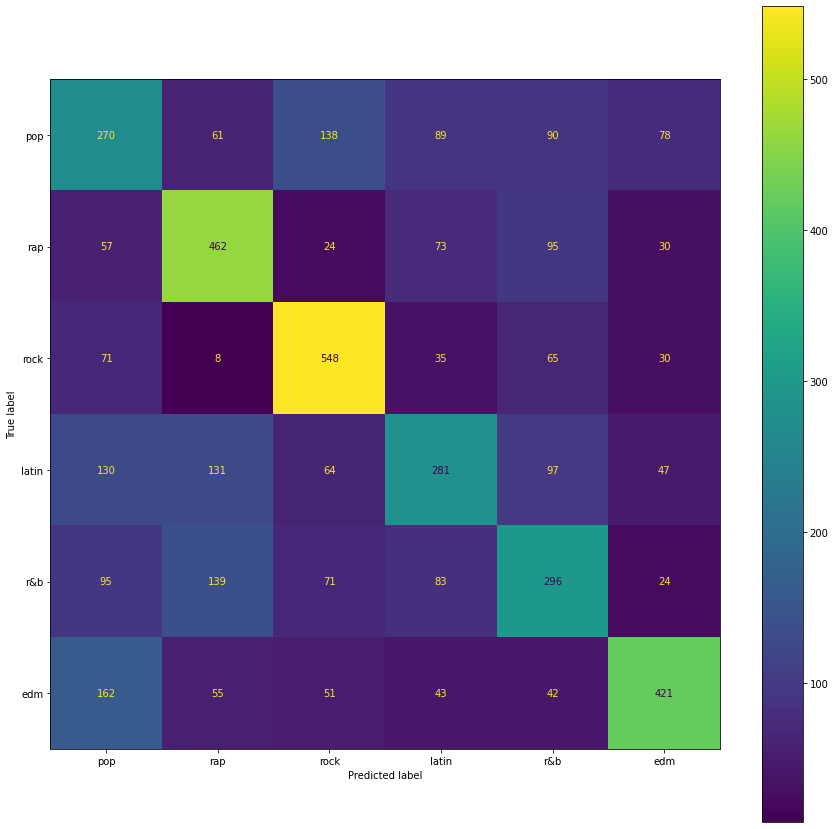

In [61]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## AdaBoost


In [84]:
# AdaBoost
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, n_estimators=50, learning_rate=1, random_state=42)
adaboost_model.fit(songs_data_train2, songs_target_train2)
y_pred = adaboost_model.predict(songs_data_test2)

accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

c:\Users\MachB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.48473967684021546


In [85]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

18.571864493135767


In [63]:
base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample between 50 and 200
    'learning_rate': uniform(0.01, 1.0),  # Randomly sample learning_rate from a uniform distribution
}

random_search = make_random_search(adaboost_model, param_dist)
random_search.fit(songs_data_train2, songs_target_train2)

print("Best Hyperparameters:", random_search.best_params_)
best_adaboost_model = random_search.best_estimator_
y_pred = best_adaboost_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

Best Hyperparameters: {'learning_rate': 0.4048815181755697, 'n_estimators': 185}
Accuracy:  0.5067324955116697


In [88]:
#AdaBoost using best params from random serach

base_model = DecisionTreeClassifier(max_depth=1)
adaboost_model = AdaBoostClassifier(base_model, random_state=42, learning_rate=0.40, n_estimators=185)
adaboost_model.fit(songs_data_train2, songs_target_train2)
y_pred = adaboost_model.predict(songs_data_test2)

y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

c:\Users\MachB\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


17.76298537758107


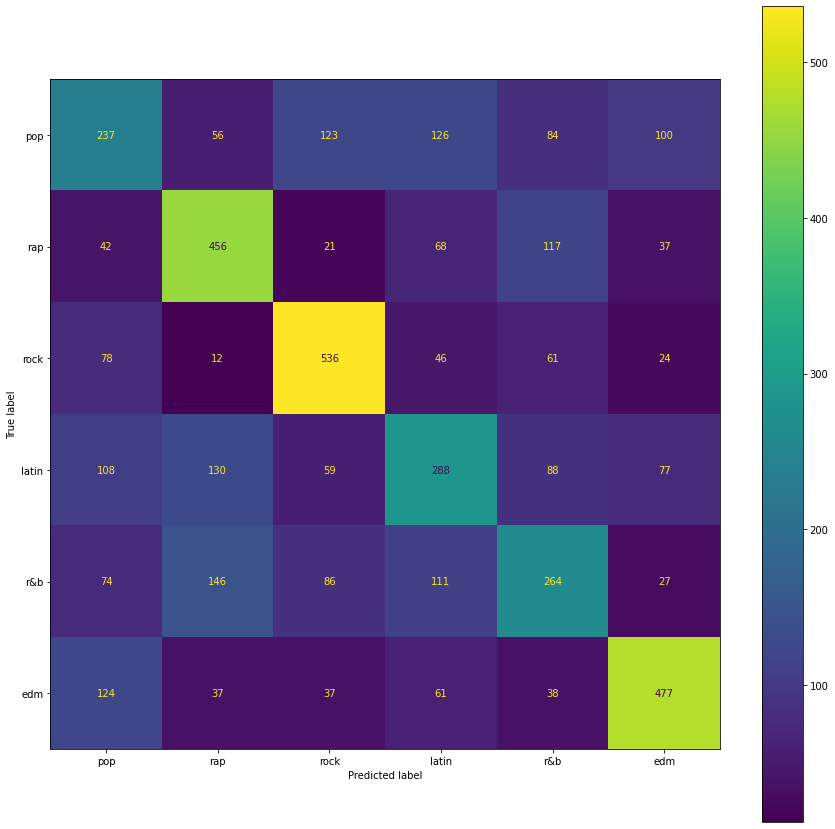

In [64]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

## Bootstrap Aggregating

In [89]:
#Bagging (Bootstrap Aggregating)
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, n_estimators=50, random_state=42)
bagging_model.fit(songs_data_train2, songs_target_train2)
y_pred = bagging_model.predict(songs_data_test2)

accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

Accuracy:  0.551391382405745


In [90]:
y_pred_binarized = label_binarize(y_pred, classes=list(set(y_pred)))
y_true_binarized = label_binarize(songs_target_test2, classes=list(set(songs_target_test2)))
cross_entropy = log_loss(y_true_binarized, y_pred_binarized)
print(cross_entropy)

16.169493519938328


In [66]:
base_model = DecisionTreeClassifier()
bagging_model = BaggingClassifier(base_model, random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),  # Randomly sample between 50 and 200
    'max_samples': uniform(0.1, 1.0),  # Randomly sample max_samples from a uniform distribution
    'max_features': uniform(0.1, 1.0)  # Randomly sample max_features from a uniform distribution
}

random_search = make_random_search(bagging_model, param_dist)

random_search.fit(songs_data_train2, songs_target_train2)
print("Best Hyperparameters:", random_search.best_params_)
best_bagging_model = random_search.best_estimator_
y_pred = best_bagging_model.predict(songs_data_test2)
accuracy = accuracy_score(songs_target_test2, y_pred)
print("Accuracy: ", accuracy)

c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
39 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\natal\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py

Best Hyperparameters: {'max_features': 0.762522284353982, 'max_samples': 0.41171107608941093, 'n_estimators': 183}
Accuracy:  0.5617145421903053


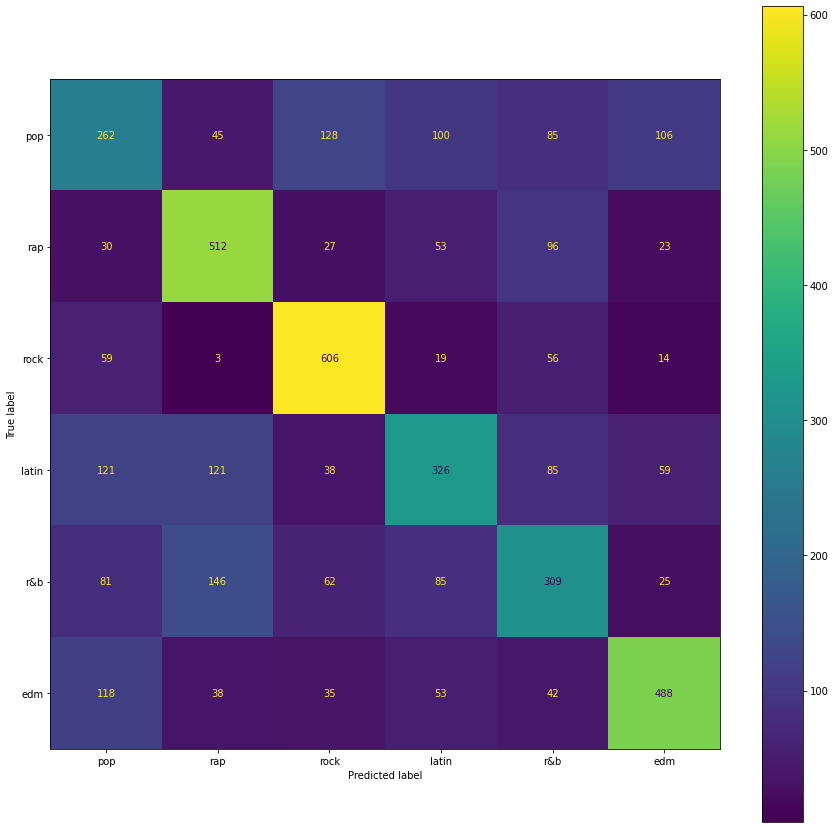

In [67]:
# confusion matrix
conf_matrix = confusion_matrix(songs_target_test2,y_pred)
disp = ConfusionMatrixDisplay(conf_matrix,display_labels=map_genres)
disp.plot()

### Results comparison

In [114]:
data = [
    ['Naive bayes classifier', 0.44, 20.05],
    ['Multiclass Logistic Regression', 0.47, 19.00],
    ['Decision tree', 0.47, 19.12],
    ['Random forest', 0.56, 15.77],
    ['KNN (not normalized data)', 0.30, 25.01],
    ['KNN (normalized data)', 0.46, 19.11],
    ['KNN(after log transformation)', 0.40, 21.57],
    ['KNN (on important features', 0.50, 17.69],
    ['Support Vector Machine', 0.51, 17.41],
    ['AdaBoost', 0.50, 17.76],
    ['Bootstrap Aggregating', 0.55, 16.16],
]
column_names = ['Method', 'Accuracy', 'Cross-entropy']
df = pd.DataFrame(data, columns=column_names)
df_sorted = df.sort_values(by='Accuracy', ascending=True)

print(df_sorted)

                            Method  Accuracy  Cross-entropy
4        KNN (not normalized data)      0.30          25.01
6    KNN(after log transformation)      0.40          21.57
0           Naive bayes classifier      0.44          20.05
5            KNN (normalized data)      0.46          19.11
1   Multiclass Logistic Regression      0.47          19.00
2                    Decision tree      0.47          19.12
7       KNN (on important features      0.50          17.69
9                         AdaBoost      0.50          17.76
8           Support Vector Machine      0.51          17.41
10           Bootstrap Aggregating      0.55          16.16
3                    Random forest      0.56          15.77
